# Task:5 Model Building


  This colab notebook is created as the part of Omdena São Paulo Chapter challenge: **Classification of Plant Diseases in Brazilian Agriculture Using Computer Vision and Machine Learning**


  Collaborator: Dimitra Muni (muni.dimitra@gmail.com)

In [ ]:
# Importing Necessary Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import models,layers,utils
import pandas as pd


: 

In [3]:
# Using the remote drive to import the BRACOL dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Pre-processing

- The BRACOL dataset has already been pre-processed and augmented with images

In [4]:
# BRACOL images have three colour channels, with all the images of 256 x 256 resolution, choosing a seed value for reproducibility
# batchsize is selected be 32
IMAGE_L=256
IMAGE_W=256
IMAGE_SIZE=(IMAGE_L,IMAGE_W)
BATCH_SIZE=32
SEED_VALUE=1728
n_channel=3

In [5]:
training_ds=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/coffee-datasets/symptom/train',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED_VALUE
)

Found 1549 files belonging to 5 classes.


In [6]:
validation_ds=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/coffee-datasets/symptom/val',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED_VALUE
)

Found 335 files belonging to 5 classes.


In [7]:
test_ds=tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/coffee-datasets/symptom/test',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED_VALUE
)

Found 335 files belonging to 5 classes.


In [8]:
"Extracting the class names "


['health', 'miner', 'rust', 'phoma', 'cercospora']


In [65]:
def class_label_distribution(dataset):
  class_names_raw=dataset.class_names
  class_names=[cls.split('_')[1] for cls in class_names_raw]
  n_classes=len(class_names)
  print(f"Number of classes in the dataset are {n_classes}")
  dataset_total_labels=[]
  for ib,lb in dataset:
    dataset_total_labels+=[class_names[lb] for lb in lb.numpy()]

  label_value_counts=pd.Series(dataset_total_labels).value_counts()
  print(f"Number of labels for each class are following:\n{label_value_counts}")
  print(label_value_counts.plot.pie())


Number of classes in the dataset are 5
Number of labels for each class are following:
rust          444
miner         374
phoma         325
cercospora    224
health        182
dtype: int64
Axes(0.22375,0.11;0.5775x0.77)


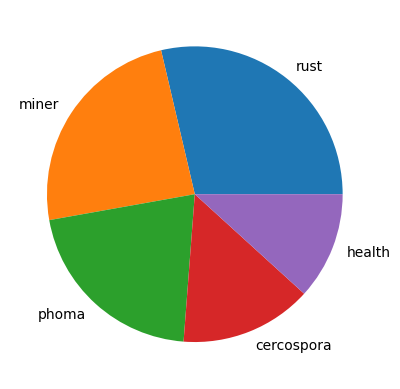

In [66]:
class_label_distribution(training_ds)

Number of classes in the dataset are 5
Number of labels for each class are following:
rust          93
miner         83
phoma         70
cercospora    49
health        40
dtype: int64
Axes(0.22375,0.11;0.5775x0.77)


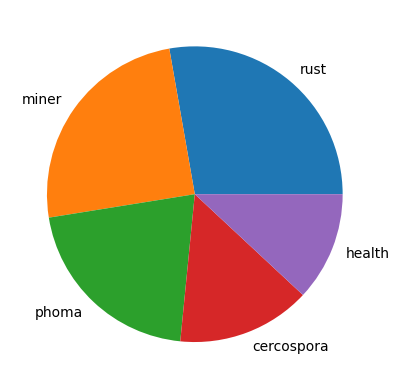

In [67]:
class_label_distribution(validation_ds)

Number of classes in the dataset are 5
Number of labels for each class are following:
rust          94
miner         83
phoma         69
cercospora    50
health        39
dtype: int64
Axes(0.22375,0.11;0.5775x0.77)


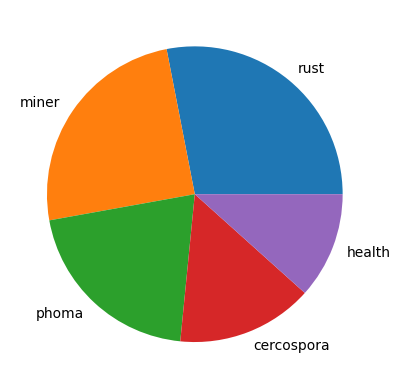

In [68]:
class_label_distribution(test_ds)

In [9]:
"Plotting training images"
#plt.figure(figsize=(12,12))
#for ib,lb in training_ds.take(1):
#    for i in range(1):
#        ax=plt.subplot(3,5,i+1)
#        plt.imshow(ib[i].numpy().astype('uint8'))
#        plt.title(training_ds.class_names[lb[i].numpy()],fontsize=8)
#        plt.axis('off')

In [10]:
#Optimizing the dataset with caching and prefetching
#Look at the following link for more information,https://www.tensorflow.org/guide/data_performance
def optimized_dataset(ds):
  return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [11]:
train=optimized_dataset(training_ds)
valid=optimized_dataset(validation_ds)
test=optimized_dataset(test_ds)

#Building  CNN

In [12]:
input_shape=(BATCH_SIZE,IMAGE_L,IMAGE_W,n_channel)

def bulid_CNN(n_convo_layers=4,n_filters=4,n_dense_layers=3,n_nodes=64,drop_out=True):

  "Part:1 NN Skeleton followed by rescaling layer"

  #setting up sequential model
  model= tf.keras.Sequential()

  #rescaling the image
  model.add(layers.experimental.preprocessing.Rescaling(1.0/255))

  "Part:2 Convolution and Pooling"

  #first convolution layer
  model.add(layers.Conv2D(filters=n_filters,kernel_size=(3,3),activation='relu',input_shape=input_shape,padding='same'))

  model.add(layers.MaxPooling2D(pool_size=(2,2)))

  #adding subsequent convolution layers
  for i in range(n_convo_layers-1):

    model.add(layers.Conv2D(filters=2*(i+1)*n_filters,kernel_size=(3,3),activation='relu',padding='same'))

    model.add(layers.MaxPooling2D(pool_size=(2,2)))


  "Part:3 ANN"

  #flattening prior to dense layers
  model.add(layers.Flatten())

  #adding dense layer followed by batch normalization and drop out (if True)
  for i in range(n_dense_layers-1):
    model.add(layers.Dense(n_nodes,activation='relu'))
    model.add(layers.BatchNormalization())
    if drop_out==True:
      model.add(layers.Dropout(0.5))

  #final dense layer
  model.add(layers.Dense(n_classes,activation='softmax'))

  model.build(input_shape=input_shape)

  print(model.summary())

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics='accuracy')

  return model

In [13]:
model1=bulid_CNN(n_convo_layers=8,n_filters=32,n_dense_layers=2,n_nodes=64,drop_out=True)
#callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0000001,verbose=1)
history1=model1.fit(
    train,
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=valid)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 64, 64, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 64, 64, 128)         7

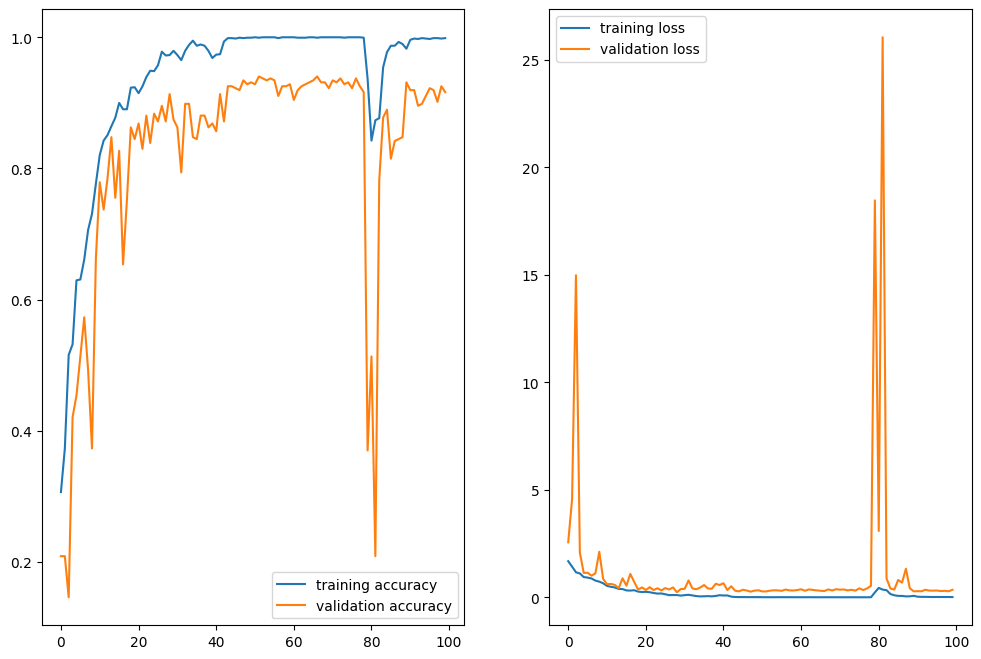

In [74]:
def plot_evaluation_curves(history):

  plt.figure(figsize=(12,8))
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['training accuracy','validation accuracy'])

  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['training loss','validation loss'])
plot_evaluation_curves(history1)

1/1 [==============================] - 0s 31ms/step


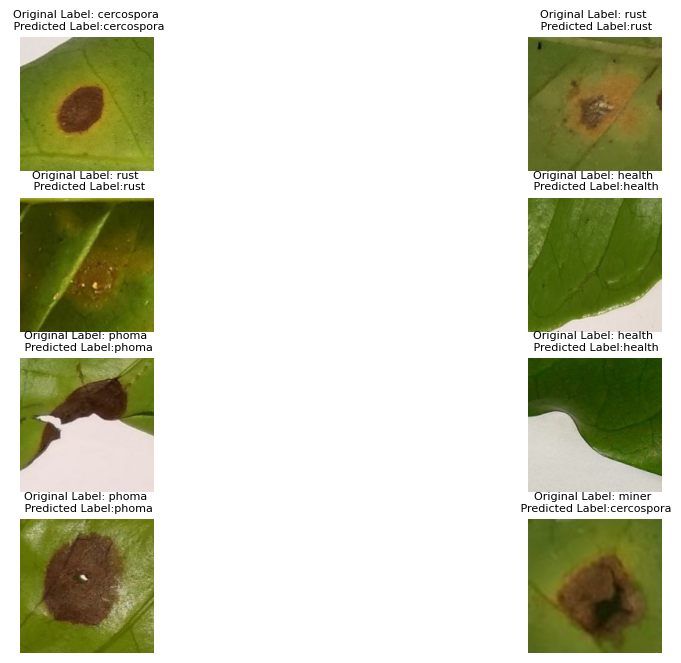

In [69]:
plt.figure(figsize=(12,8))

for image_batch,label_batch in test_ds.take(1):
    batch_prediction=model1.predict(image_batch)
    for i in range(8):
        plt.subplot(4,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(f'Original Label: {class_names[label_batch[i].numpy()]} \n Predicted Label:{class_names[np.argmax(batch_prediction[i])]}',fontsize=8)
        plt.axis('off')

In [16]:
from sklearn.metrics import classification_report
def compute_accuracy(model=model1,ds=test):
  original_labels=[]
  predicted_labels=[]
  for image_batch,label_batch in ds:
      batch_prediction=model1.predict(image_batch)
      #print(image_batch)
      current_batch_original_labels=[class_names[lb] for lb in label_batch.numpy()]
      original_labels=original_labels+current_batch_original_labels

      #np.argmax(batch_prediction[i])

      current_batch_predicted_labels=[class_names[label] for label in [np.argmax(a) for a in batch_prediction]]
      predicted_labels=predicted_labels+current_batch_predicted_labels

  print(classification_report(original_labels,predicted_labels))

compute_accuracy(ds=train)
compute_accuracy(ds=valid)
compute_accuracy(ds=test)


1/1 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

  cercospora       1.00      1.00      1.00       224
      health       1.00      1.00      1.00       182
       miner       1.00      1.00      1.00       374
       phoma       1.00      1.00      1.00       325
        rust       1.00      1.00      1.00       444

    accuracy                           1.00      1549
   macro avg       1.00      1.00      1.00      1549
weighted avg       1.00      1.00      1.00      1549

1/1 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

  cercospora       0.78      0.94      0.85        49
      health       1.00      0.95      0.97        40
       miner       0.92      0.86      0.89        83
       phoma       0.94      0.87      0.90        70
        rust       0.95      0.98      0.96        93

    accuracy                           0.92       335
   macro avg       0.92    

In [17]:
model1.save('model_CNN1.h5')

# References
  - 1) [Deep learning for classification and severity estimation of coffee leaf biotic stress](https://arxiv.org/abs/1907.11561)
  - 2) [Image classification using CNN](https://www.youtube.com/watch?v=7HPwo4wnJeA), A Tutorial by Codebasics
  - 3) [Potato Disease Identification End to End Project](https://www.youtube.com/playlist?list=PLeo1K3hjS3ut49PskOfLnE6WUoOp_2lsD)
  - 4) [Optimize Pipeline Performance](https://www.tensorflow.org/guide/data_performance)